In [72]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import streamlit as st
from adjustText import adjust_text
from lightgbm import LGBMClassifier
from matplotlib import cm
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tabulate import tabulate

# Exploring Obesity Trends: Visual Data Analysis and Predictive Modeling Using LightGBM

## Study Goals


The goal of this study is to practice data exploration techniques and to build a model to classify if individuals into weight classes based on personal factors.
Packages used include: Pandas, Seaborn, Matplotlib, lighgbm, Optuna, SKlearn.




## Dataset Overview



The dataset originates from a study estimating obesity levels in individuals aged 14 to 61 from Mexico, Peru, and Colombia. 
It reflects diverse eating habits and physical conditions, collected through a web-based survey where anonymous participants 
answered various questions. The dataset includes 17 attributes and 2,111 records, with key variables covering eating habits 
such as the consumption of high-caloric food (FAVC), vegetables (FCVC), meals (NCP), snacks (CAEC), water (CH20), and alcohol (CALC). 
Physical condition metrics include calorie monitoring (SCC), physical activity (FAF), screen time (TUE), and transportation mode (MTRANS). 
Demographic and anthropometric data like gender, age, height, and weight are also included. Obesity levels are categorized into six classes: 
Underweight, Normal, Overweight, Obesity I, II, and III, based on BMI thresholds. This data provides a comprehensive overview for analyzing 
the impact of lifestyle choices on obesity trends.



"The dataset used in this project can be found on [Kaggle](https://www.kaggle.com/datasets/aravindpcoder/obesity-or-cvd-risk-classifyregressorcluster). The data has since been expanded by kaggle to provide a larger training set."

## A Quick Glance at the Data

In [73]:
# Load datasets
df_train = pd.read_csv(os.path.join(os.getcwd(), "project_1_data", "train.csv"))
df_original = pd.read_csv(
    os.path.join(os.getcwd(), "project_1_data", "ObesityDataSet.csv")
)
df_data = pd.concat([df_train, df_original]).drop(["id"], axis=1).drop_duplicates()

## The First Few Lines"


In [74]:
df_data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


## Pretty Summary of the Data

In [75]:
#numeric Summary
numeric_cols = df_data.select_dtypes('number').columns
desc = df_data[numeric_cols].describe().transpose()
desc['#missing'] = df_data[numeric_cols].isnull().sum().values    
desc['#duplicates'] = df_data.duplicated(subset=numeric_cols).sum()
desc = desc[['#missing', 'count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
desc.style.background_gradient()

,#missing,count,mean,std,min,25%,50%,75%,max
Age,0,22845.000000,23.888513,5.755338,14.000000,20.000000,22.815416,26.000000,61.000000
Height,0,22845.000000,1.700467,0.087865,1.450000,1.631856,1.700000,1.763029,1.980000
Weight,0,22845.000000,87.793761,26.363367,39.000000,66.000000,84.000000,111.531208,173.000000
FCVC,0,22845.000000,2.443675,0.533392,1.000000,2.000000,2.393837,3.000000,3.000000
NCP,0,22845.000000,2.755837,0.711185,1.000000,3.000000,3.000000,3.000000,4.000000
CH2O,0,22845.000000,2.027165,0.608479,1.000000,1.755907,2.000000,2.531984,3.000000
FAF,0,22845.000000,0.984585,0.839728,0.000000,0.015860,1.000000,1.600431,3.000000
TUE,0,22845.000000,0.620984,0.602802,0.000000,0.000000,0.582840,1.000000,2.000000


In [76]:
top_n=3
non_numeric_cols = df_data.select_dtypes(exclude='number').columns
summary = pd.DataFrame(df_data[non_numeric_cols].dtypes, columns=["data type"])
summary['#missing'] = df_data[non_numeric_cols].isnull().sum().values
summary['#unique'] = df_data[non_numeric_cols].nunique().values
summary['#duplicates'] = df_data[non_numeric_cols].duplicated().sum()
most_frequent = df_data[non_numeric_cols].mode().iloc[0]
freq = df_data[non_numeric_cols].apply(lambda x: x.value_counts().iloc[0] if x.notnull().any() else 0)
summary['Most Frequent'] = most_frequent.values
summary['Freq'] = freq.values
mode_counts = df_data[non_numeric_cols].apply(lambda x: x.value_counts().iloc[0] if x.notnull().any() else 0)
summary['Mode Count'] = mode_counts.values
summary['Mode Percentage'] = (summary['Freq'] / df_data[non_numeric_cols].shape[0]) * 100
summary['Cardinality'] = summary['#unique'] / df_data[non_numeric_cols].shape[0]
summary['Null Percentage'] = (summary['#missing'] / df_data[non_numeric_cols].shape[0]) * 100
top_n_values = df_data[non_numeric_cols].apply(lambda x: x.value_counts().nlargest(top_n).index.tolist() if x.notnull().any() else [])
summary['Top N Frequent'] = top_n_values.apply(lambda x: ', '.join(map(str, x))).values
first_occurrence = df_data[non_numeric_cols].apply(lambda x: x.dropna().iloc[0] if not x.dropna().empty else np.nan)
last_occurrence = df_data[non_numeric_cols].apply(lambda x: x.dropna().iloc[-1] if not x.dropna().empty else np.nan)
summary['First Occurrence'] = first_occurrence.values
summary['Last Occurrence'] = last_occurrence.values
summary = summary[['#missing', '#unique', '#duplicates', 'Most Frequent', 'Freq', 'Mode Count', 'Mode Percentage',
                    'Cardinality', 'Null Percentage', 'Top N Frequent', 'First Occurrence', 'Last Occurrence', 'data type']]
summary

,#missing,#unique,#duplicates,Most Frequent,Freq,Mode Count,Mode Percentage,Cardinality,Null Percentage,Top N Frequent,First Occurrence,Last Occurrence,data type
Gender,0,2,21732,Female,11457,11457,50.151018,0.000088,0.0,"Female, Male",Male,Female,object
family_history_with_overweight,0,2,21732,yes,18736,18736,82.013570,0.000088,0.0,"yes, no",yes,yes,object
FAVC,0,2,21732,yes,20826,20826,91.162180,0.000088,0.0,"yes, no",yes,yes,object
CAEC,0,4,21732,Sometimes,19290,19290,84.438608,0.000175,0.0,"Sometimes, Frequently, Always",Sometimes,Sometimes,object
SMOKE,0,2,21732,no,22556,22556,98.734953,0.000088,0.0,"no, yes",no,no,object
SCC,0,2,21732,no,22062,22062,96.572554,0.000088,0.0,"no, yes",no,no,object
CALC,0,4,21732,Sometimes,16446,16446,71.989494,0.000175,0.0,"Sometimes, no, Frequently",Sometimes,Sometimes,object
MTRANS,0,5,21732,Public_Transportation,18245,18245,79.864303,0.000219,0.0,"Public_Transportation, Automobile, Walking",Public_Transportation,Public_Transportation,object
NObeyesdad,0,7,21732,Obesity_Type_III,4370,4370,19.128912,0.000306,0.0,"Obesity_Type_III, Obesity_Type_II, Normal_Weight",Overweight_Level_II,Obesity_Type_III,object


In [77]:
#Make a table of non-numeric unique items. This helps in pre-processing
non_numeric_cols = df_data.select_dtypes(exclude=['number']).columns
unique_values_summary = {
    'Column': [],
    'Unique Values': []
}
for col in non_numeric_cols:
    unique_values_summary['Column'].append(col)
    unique_values_summary['Unique Values'].append(df_data[col].unique())
summary_df = pd.DataFrame(unique_values_summary)
summary_df

,Column,Unique Values
0,Gender,"[Male, Female]"
1,family_history_with_overweight,"[yes, no]"
2,FAVC,"[yes, no]"
3,CAEC,"[Sometimes, Frequently, no, Always]"
4,SMOKE,"[no, yes]"
5,SCC,"[no, yes]"
6,CALC,"[Sometimes, no, Frequently, Always]"
7,MTRANS,"[Public_Transportation, Automobile, Walking, M..."
8,NObeyesdad,"[Overweight_Level_II, Normal_Weight, Insuffici..."


In [78]:
# Process each non-numeric column into bool, ordinal, and categorical using the knowledge from previous
ordinal_mappings = {
    'CAEC': ['no', 'Sometimes', 'Frequently', 'Always'],  # Ordinal categories
    'CALC': ['no', 'Sometimes', 'Frequently'],  # Ordinal categories
    'NObeyesdad' : [ "Insufficient_Weight", "Normal_Weight", "Overweight_Level_I", "Overweight_Level_II", "Obesity_Type_I","Obesity_Type_II","Obesity_Type_III"]
}
for col in df_data.select_dtypes(exclude='number').columns:
    if col == 'Gender':  # Pure categorical column
        df_data[col] = df_data[col].astype('category')
    elif col in ['family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']:  # Yes/No columns
        df_data[col] = df_data[col].map({'yes': True, 'no': False}).astype(bool)
    elif col in ordinal_mappings:  # Ordinal columns
        # Create a categorical column with specified order
        df_data[col] = pd.Categorical(df_data[col], categories=ordinal_mappings[col], ordered=True)
    else:  # Categorical column with no specific ordering
        df_data[col] = df_data[col].astype('category')

Key information from the summary is that:
1. There are no missing values across the dataset.
2. There is a variable "NObeyesdad" identifying individuals' weight class. This will be our response variable, which we want to classify by.

## Investigating Individual Features

After a cursory glance at the data to ensure it is clean and free from missing values, we proceed to examine the individual features in detail. This step involves analyzing the distribution, relationships, and patterns within each feature to gain insights and identify any anomalies or trends that might influence the subsequent modeling process.

## Investigating Native Data Features

We will first look at the data that is naturally included in the data. A table of abbreviations and their associated meanings is included for reader accessibility if they are following along in the data.


In [79]:
def showplot(columnname, title, dataframe):
    colors = plt.colormaps['Pastel1'].colors

    df_counts = (
        dataframe[columnname]
        .value_counts()
        .reset_index()
        .rename(columns={columnname: 'Value', 'count': 'Count'})
        .sort_values(by='Value', ascending=True)
    )
    

    # Set figure and axis
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    # Bar Chart
    bars = ax[0].barh(y=df_counts['Value'].astype(str), 
            width=df_counts['Count'],
            color = colors)
    # Annotate bars with counts
    for bar in bars:
        count = bar.get_width()  # Width corresponds to the x-value in a horizontal bar
        y = bar.get_y() + bar.get_height() / 2  # Get the y-position at the center of the bar
        
        ax[0].text(
            count + 1,  # Slightly offset to the right of the bar
            y,  # Vertical position
            str(count),  # The count as a string
            va="center",  # Center alignment vertically
            ha="left",  # Left alignment horizontally
            fontsize=10,  # Font size
            color="black",  # Font color
        )

    ax[0].set_title("As Counts", fontsize=12)
    ax[0].spines["top"].set_visible(False)  # Remove top border
    ax[0].spines["right"].set_visible(False)  # Remove right border
    ax[0].grid(True, axis='x', linestyle='--', alpha=0.7, zorder=0)


    # Pie Chart
    wedges, texts, autotexts = ax[1].pie(
        x= df_counts['Count'], 
        labels=df_counts['Value'],
        autopct='%1.1f%%', 
        pctdistance = 0.8,
        startangle=90,
        colors = colors)
    ax[1].set_title("As Percentages", fontsize=12)
    
    text_objects = texts + autotexts

    # Adjust the positions of labels and percentage text
    if len(df_counts['Value']) > 3 and len(df_counts['Value']) < 6:
        adjust_text(
            text_objects,
            expand_text=(1.05, 1.1),  # Allow some leeway for label movement
            arrowprops=dict(arrowstyle="-", color="gray"),  # Optional arrows for clarity
            ax=ax[1]  # Specify which subplot the adjustment applies to
        )
    # Set title and layout
    fig.suptitle(title, fontsize=15)
    plt.tight_layout()
    fig

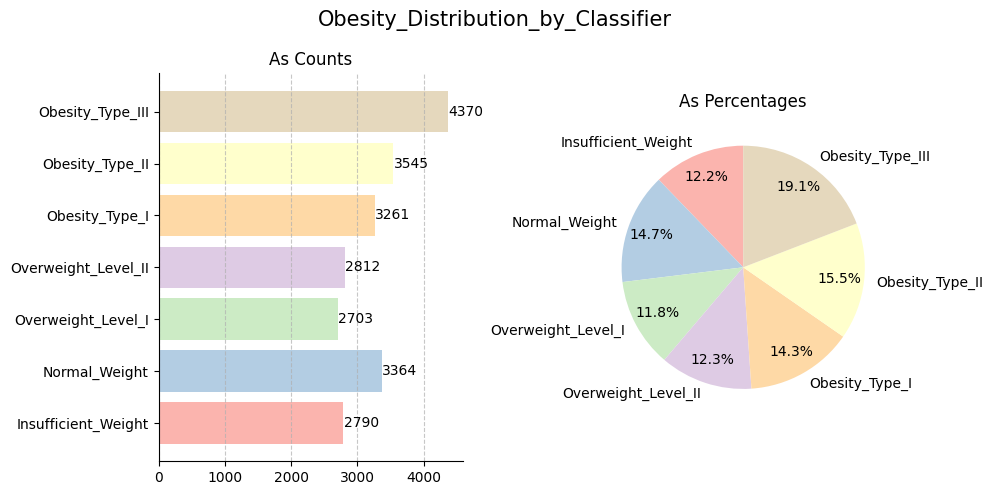

In [80]:
showplot("NObeyesdad", "Obesity_Distribution_by_Classifier", df_data)

• The data shows a clear prevalence of obesity, with nearly 20% of individuals classified as Type 3 obese. This highlights the significant representation of individuals with severe obesity in the dataset, underscoring the need for targeted interventions to address this issue.

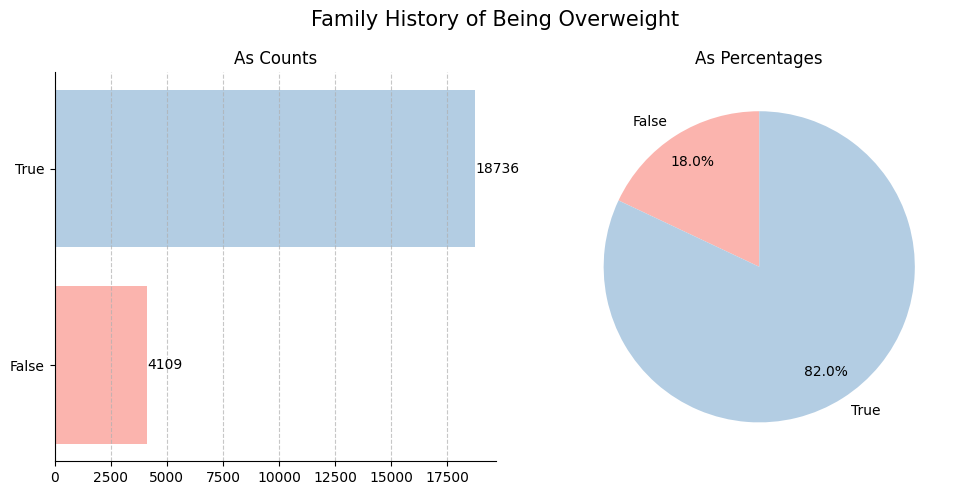

In [81]:
showplot("family_history_with_overweight", "Family History of Being Overweight", df_data)

• A majority of individuals in the dataset reported having family members who are overweight, suggesting a potential genetic or environmental influence on weight-related health outcomes. This underscores the importance of considering family history when assessing obesity risks. However, it may be from confounding situations such as family members having the same dietary habits and compsitions.

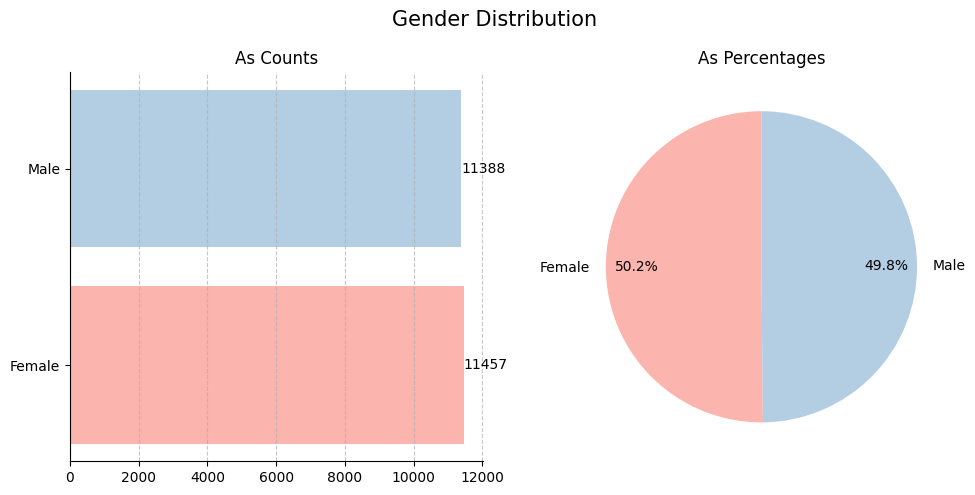

In [82]:
showplot("Gender", "Gender Distribution", df_data)

• The dataset is nearly evenly split between male and female individuals, providing a balanced view of gender representation in the analysis. This allows for more equitable comparisons across gender-specific trends and patterns.

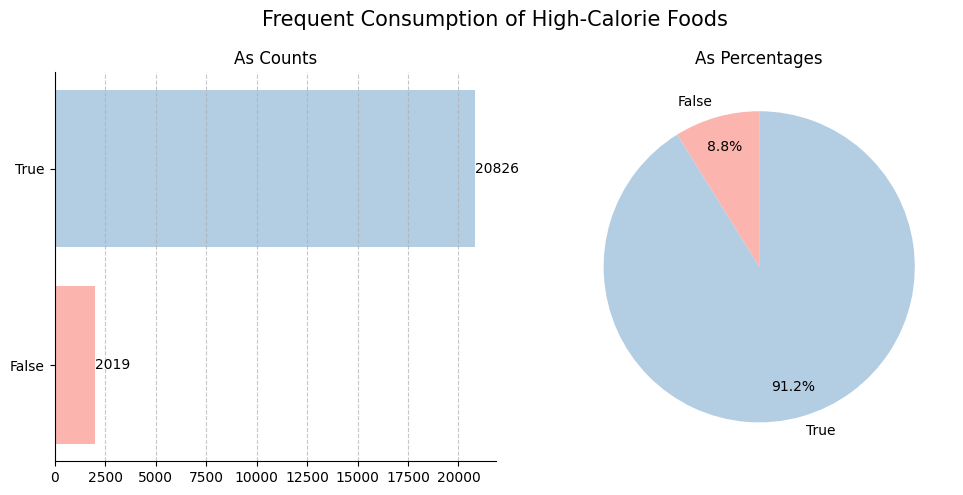

In [83]:
showplot("FAVC", "Frequent Consumption of High-Calorie Foods", df_data)

• Most individuals in the dataset report frequent consumption of high-calorie foods, such as fast food. This trend indicates that dietary habits may play a significant role in the observed obesity rates, making it a critical area for intervention strategies. It is common knowledge that high calorie foods are often cheaper than healthier options. While the socioeconomic data of individuals is not included in the data, it would be a scope of interesting further study.

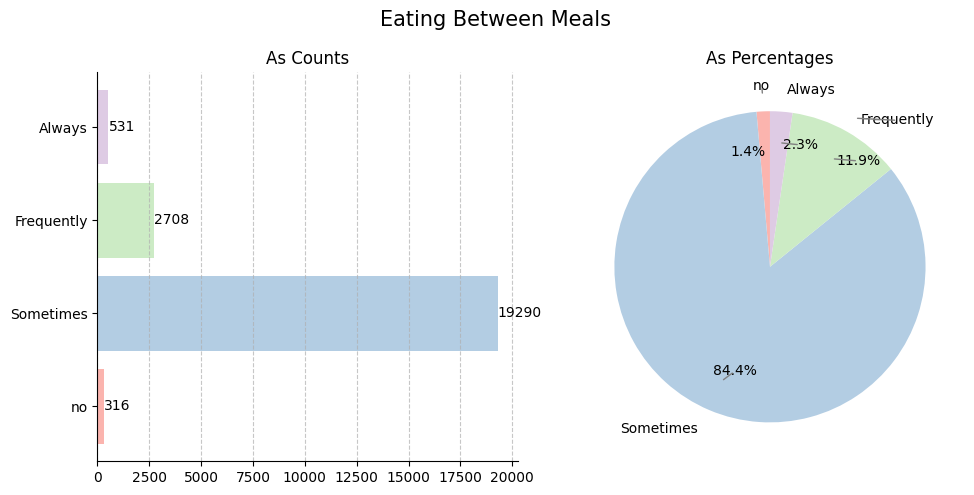

In [84]:
showplot("CAEC", "Eating Between Meals", df_data)

• The majority of individuals fall in the 'sometimes' category for eating between meals, indicating a moderate tendency toward snacking. This behavior could be a contributing factor to overall caloric intake, especially if snacks are high in calories. Hidden calories, or calories that people don't consider or internalize or are not readily apparent as they snack can play into this figure though it is outside scope of this data.

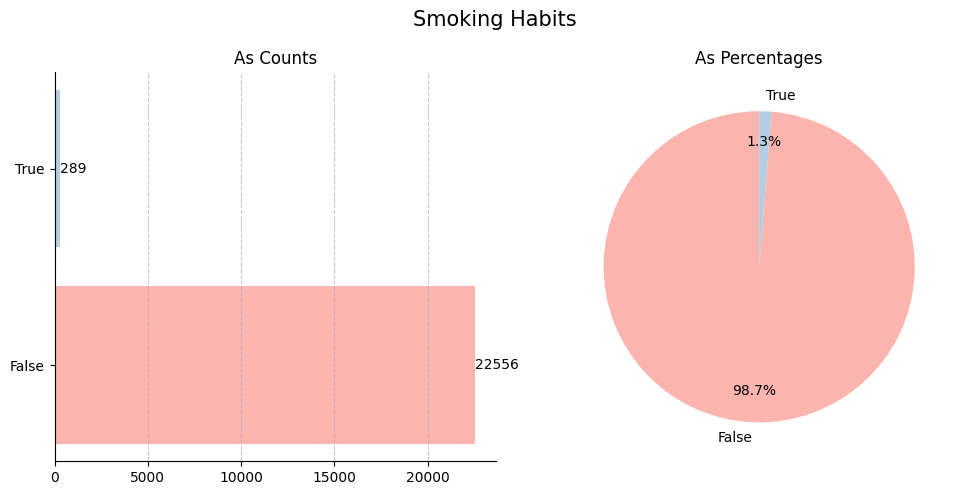

In [85]:
showplot("SMOKE", "Smoking Habits", df_data)

• Smoking is relatively uncommon among individuals in the dataset. While smoking is not a major factor here, its role in metabolism and weight regulation could still be worth considering in a broader analysis.

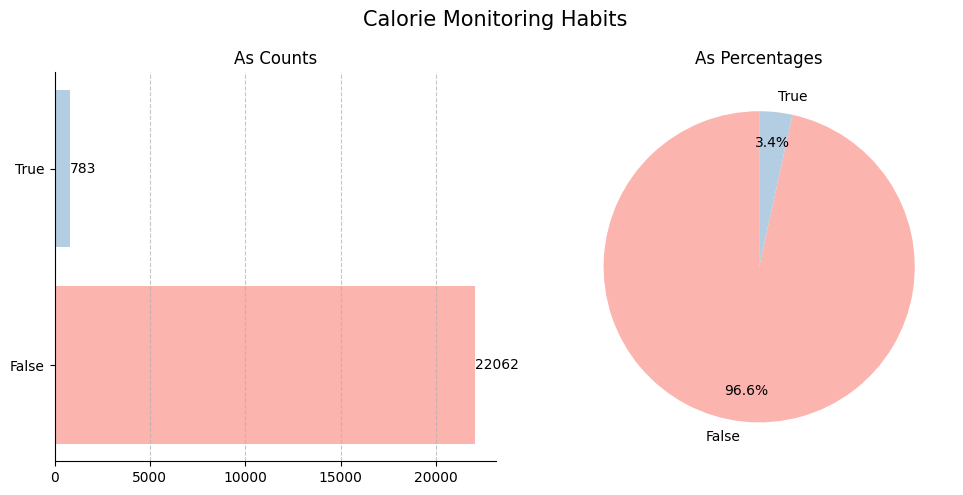

In [86]:
showplot("SCC", "Calorie Monitoring Habits", df_data)

• Most individuals do not monitor their calorie consumption. This lack of awareness may contribute to poor dietary choices and overconsumption, which are significant factors in weight management and obesity prevention.

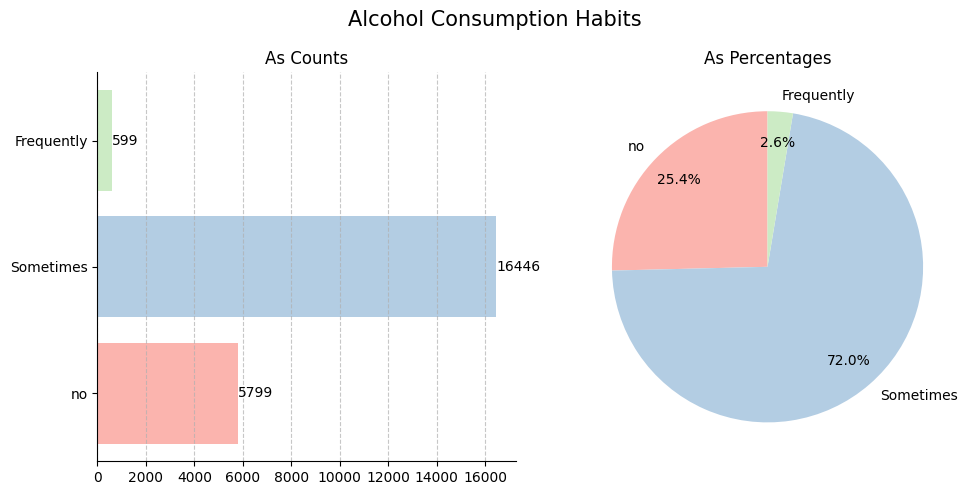

In [87]:
showplot("CALC", "Alcohol Consumption Habits", df_data)

• Alcohol consumption patterns indicate that most individuals are either moderate drinkers or occasional drinkers. While alcohol may not be a primary driver of obesity, its caloric contribution should not be overlooked in dietary assessments.

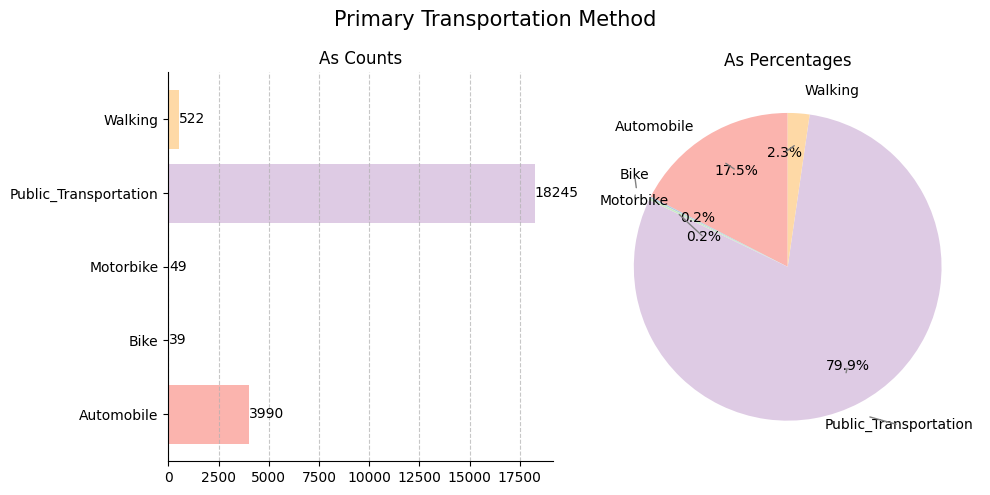

In [88]:
showplot("MTRANS", "Primary Transportation Method", df_data)

• Nearly 97% of individuals rely on motorized transportation, with very few walking or cycling. This sedentary mode of travel may reduce overall physical activity levels, which is a key factor in maintaining a healthy weight.


## Exploring Obesity and its Primary Factors

While the dataset contains various health-related attributes and the primary objective is to classify obesity types, it is notable that the native data lacks a BMI feature. This is particularly significant as BMI is a key determinant in classifying obesity and overweight categories. Deriving and exploring this feature could provide valuable insights into the response variable. Additionally, based on background knowledge and commonly available BMI calculators, BMI can be calculated using weight, height, and age. Therefore, creating and analyzing this new feature may offer a deeper understanding of the data and its relationship to the target variable.

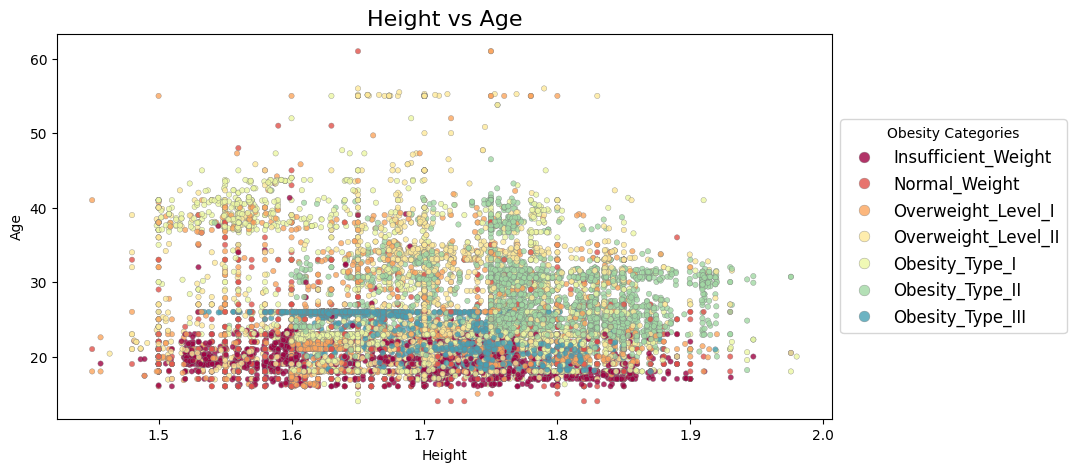

In [89]:
#scatter plot 1 height vs age
#ploting_height_vs_age
labels = df_data["NObeyesdad"].cat.categories.tolist()
cmap = plt.colormaps["Spectral"]
colors = [cmap(i / len(labels)) for i in range(len(labels))]
# Scatter plot: Height vs Age
fig, ax = plt.subplots(figsize=(10, 5))  # Larger figure size for better visibility
sns.scatterplot(
    x=df_data["Height"],
    y=df_data["Age"],
    hue=df_data["NObeyesdad"],  # Column for grouping
    palette=dict(zip(labels, colors)),  # Map labels to colors
    edgecolor="grey",
    alpha=0.8,
    ax=ax,
    s = 15
)
# Add title and remove default legend
ax.set_title("Height vs Age", fontsize=16)
ax.legend_.remove()  # Remove the default legend created by seaborn
# Create a custom legend with re-ordered handles and labels
handles, labels_legend = ax.get_legend_handles_labels()
ordered_handles = [handles[labels_legend.index(label)] for label in labels]
ordered_labels = labels
# Place custom legend outside the plot
ax.legend(
    ordered_handles,
    ordered_labels,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    ncol=1,
    title="Obesity Categories",
    scatterpoints=3,
    markerscale=2.0, 
    fontsize=12,
)

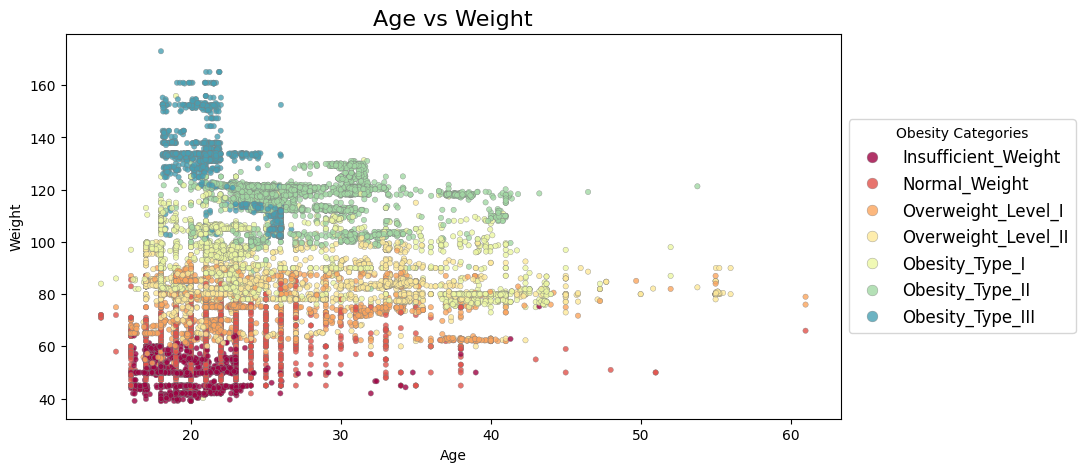

In [90]:
# Scatter plot 2: Age vs Weight
# Define colors for the obesity categories
labels = df_data["NObeyesdad"].cat.categories.tolist()
cmap = plt.colormaps["Spectral"]
colors = [cmap(i / len(labels)) for i in range(len(labels))]
# Scatter plot: Height vs Age
fig, ax = plt.subplots(figsize=(10, 5))  # Larger figure size for better visibility
sns.scatterplot(
    x=df_data["Age"],
    y=df_data["Weight"],
    hue=df_data["NObeyesdad"],  # Column for grouping
    palette=dict(zip(labels, colors)),  # Map labels to colors
    edgecolor="grey",
    alpha=0.8,
    ax=ax,
    s = 15
)
# Add title and remove default legend
ax.set_title("Age vs Weight", fontsize=16)
ax.legend_.remove()  # Remove the default legend created by seaborn
# Create a custom legend with re-ordered handles and labels
handles, labels_legend = ax.get_legend_handles_labels()
ordered_handles = [handles[labels_legend.index(label)] for label in labels]
ordered_labels = labels
# Place custom legend outside the plot
ax.legend(
    ordered_handles,
    ordered_labels,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    ncol=1,
    title="Obesity Categories",
    scatterpoints=3,
    markerscale=2.0, 
    fontsize=12,
)

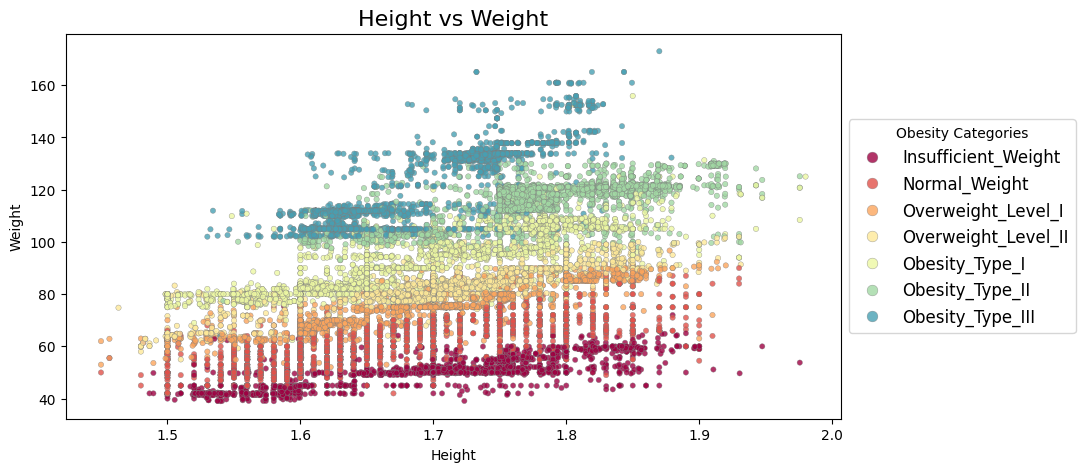

In [91]:
# Scatter plot 3: Height vs Weight
# Define colors for the obesity categories
labels = df_data["NObeyesdad"].cat.categories.tolist()
cmap = plt.colormaps["Spectral"]
colors = [cmap(i / len(labels)) for i in range(len(labels))]
# Scatter plot: Height vs Age
fig, ax = plt.subplots(figsize=(10, 5))  # Larger figure size for better visibility
sns.scatterplot(
    x=df_data["Height"],
    y=df_data["Weight"],
    hue=df_data["NObeyesdad"],  # Column for grouping
    palette=dict(zip(labels, colors)),  # Map labels to colors
    edgecolor="grey",
    alpha=0.8,
    ax=ax,
    s = 15
)
# Add title and remove default legend
ax.set_title("Height vs Weight", fontsize=16)
ax.legend_.remove()  # Remove the default legend created by seaborn
# Create a custom legend with re-ordered handles and labels
handles, labels_legend = ax.get_legend_handles_labels()
ordered_handles = [handles[labels_legend.index(label)] for label in labels]
ordered_labels = labels
# Place custom legend outside the plot
ax.legend(
    ordered_handles,
    ordered_labels,
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    ncol=1,
    title="Obesity Categories",
    scatterpoints=3,
    markerscale=2.0, 
    fontsize=12,
)

From the plots of Age, Height, and Weight, we can see that Obesity is very related to height and weight, as the height x weight plot displays the clearest separation of the classifying variable.

## Exploring BMI as a numeric Feature

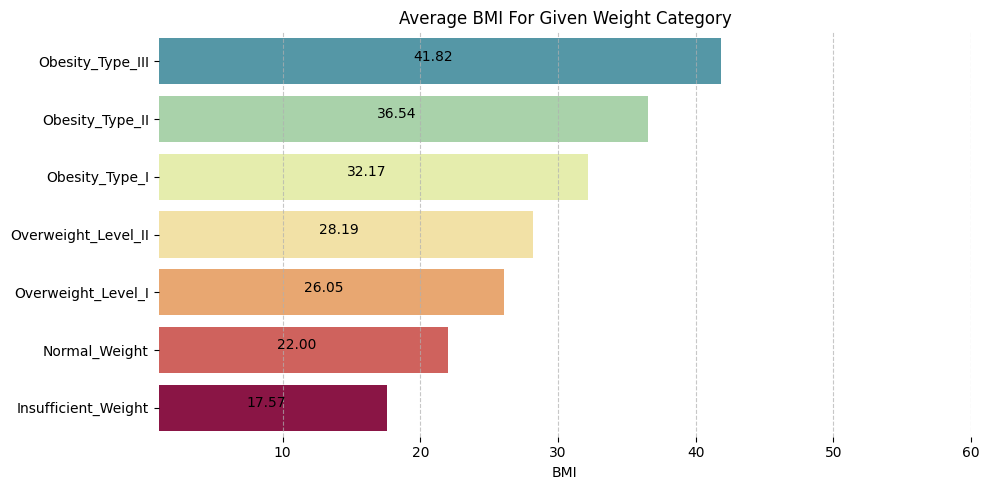

In [92]:

df_data["BMI"] = df_data["Weight"] / df_data["Height"] ** 2
# Sorting the categories based on mean BMI values
df_sort = (
    df_data.groupby("NObeyesdad", observed=False)["BMI"].mean().sort_values(ascending=False).index
)
# Create the subplots
cmap = plt.colormaps["Spectral"]
colors = [cmap(i / len(df_sort)) for i in range(len(df_sort))]

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# Bar plot (Mean BMI by NObeyesdad)
sns.barplot(
    x="BMI",
    y="NObeyesdad",
    hue="NObeyesdad",
    data=df_data,
    palette=colors,
    order=df_sort,
    estimator=np.mean,
    errorbar=None,
    legend=False,
    err_kws={'linewidth': 0},
)
# Annotate the bar chart with the mean BMI value
for p in ax.patches:
    ax.annotate(
        f"{p.get_width():.2f}",
        (p.get_x() + p.get_width() / 2.0, p.get_y() + p.get_height()),
        ha="center",
        va="center",
        xytext=(0, 20),
        textcoords="offset points",
        fontsize=10,
        color="black",
    )
ax.set_title("Average BMI For Given Weight Category")
ax.set_xlabel("BMI")
ax.set_ylabel("")
ax.grid(True, axis='x', linestyle='--', alpha=0.7, zorder=0)
plt.xlim(1, 60)
sns.despine(left=True, bottom=True, ax=ax)
plt.tight_layout()

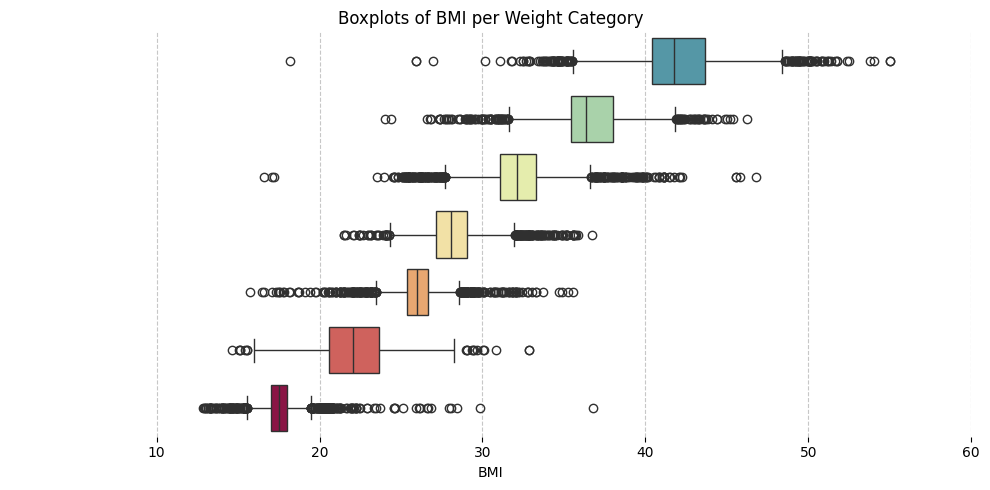

In [93]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.boxplot(
    x="BMI",
    y="NObeyesdad",
    hue="NObeyesdad",
    data=df_data,
    palette=colors,
    order=df_sort,
)
ax.set_title("Boxplots of BMI per Weight Category")
ax.set_ylabel("")
ax.grid(True, axis='x', linestyle='--', alpha=0.7, zorder=0)

plt.yticks([])  # Optionally, remove y-ticks for a cleaner look
plt.xlim(1, 60)
sns.despine(left=True, bottom=True, ax=ax)
plt.tight_layout()


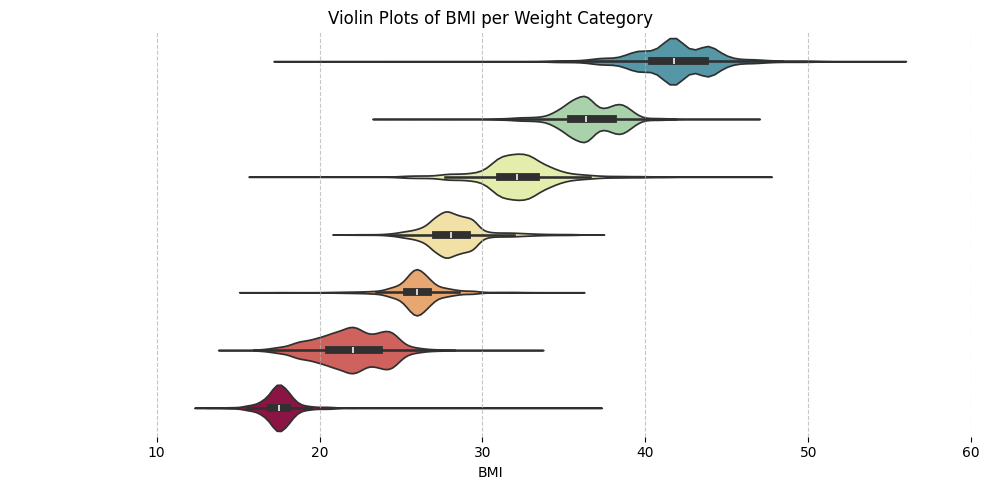

In [94]:

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.violinplot(
    x="BMI",
    y="NObeyesdad",
    hue="NObeyesdad",
    data=df_data,
    palette=colors,
    order=df_sort,
)
ax.set_title("Violin Plots of BMI per Weight Category")
ax.set_ylabel("")
ax.grid(True, axis='x', linestyle='--', alpha=0.7, zorder=0)

plt.yticks([])  # Optionally, remove y-ticks for a cleaner look
plt.xlim(1, 60)
sns.despine(left=True, bottom=True, ax=ax)
plt.tight_layout()

We can see that the Obesity classificatin data is not consistent, as the violin charts overlap, introducing difficulty in classification, as there is no clear dividing line to classify. However, it is still possible as machine learning classifies based n likelihood of belonging to a certain group.


## Investigating Further Feature Correlations


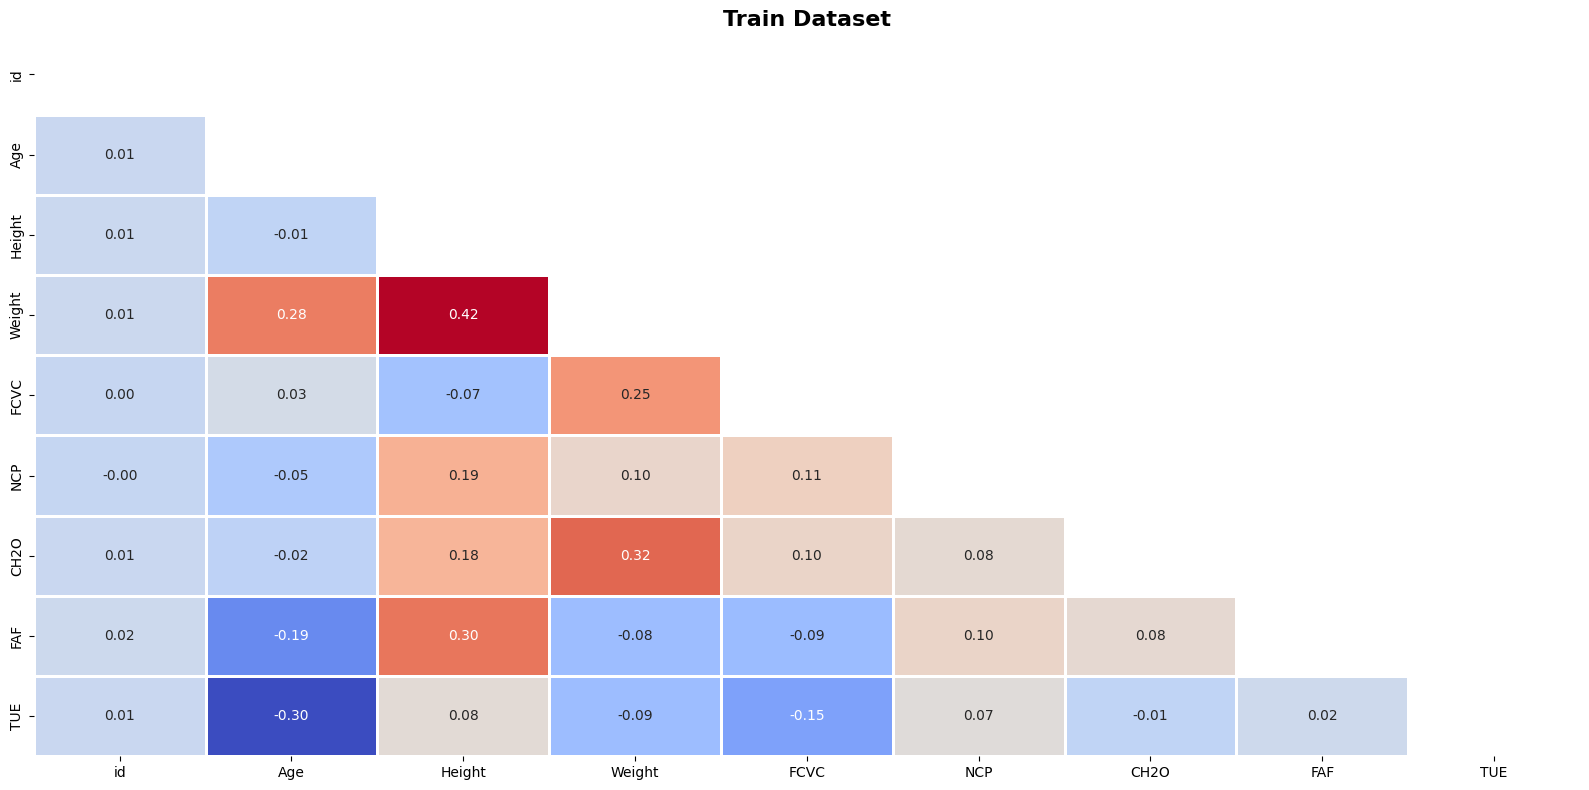

In [95]:
numeric_columns_train = df_train.select_dtypes(include=np.number)
fig, axes = plt.subplots(1, 1, figsize=(16, 8))
corr_train = numeric_columns_train.corr(method="pearson")
mask_train = np.triu(np.ones_like(corr_train))
sns.heatmap(
    corr_train,
    annot=True,
    fmt=".2f",
    mask=mask_train,
    cmap="coolwarm",
    cbar=None,
    linewidth=2,
    ax=axes,
)
axes.set_title("Train Dataset", fontsize=16, fontweight="bold")
plt.tight_layout()

From the correlaton heatmap, we can see that height and weight are highly correlated. This is understandable
We can also see that age and height, physical activity and height, vegetable consumption and weight, and water consumption and weight are also moderately correlated.
Age and time spend on technlogical devices is also negatively correlated.



## Classification


Proceeding to the classification section of this project, an LGBM Classifier was used for its ability to quickly classify large data while being resource efficient. 
LightGBM (Light Gradient Boosting Machine) is a powerful and efficient implementation of gradient boosting, a widely used technique for classification and regression tasks. 
It builds an ensemble of decision trees, where each tree corrects the errors of the previous one, ultimately producing a highly accurate model. Known for its speed, low memory usage, 
and ability to handle large datasets, LightGBM is particularly effective when dealing with datasets that have many features or large sizes. Its robustness and efficiency have made 
it a go-to choice for machine learning practitioners in both competitions and real-world applications.
         
To further optimize the performance of the LightGBM model, we used Optuna, an open-source hyperparameter optimization framework. 
Optuna automates the process of tuning machine learning models by using Bayesian optimization to explore the hyperparameter space. 
Through iterative trials, Optuna intelligently adjusts hyperparameters based on previous results to identify the optimal configuration that maximizes model performance. 
This approach not only improves model accuracy but also helps in reducing overfitting and optimizing training time, making it a valuable tool in enhancing the performance of machine learning models, including LightGBM.


In [96]:
categorical_vars = []
for column in df_data.columns:
    if df_data[column].dtype == "category":
        categorical_vars.append(column)
categorical_vars.remove("NObeyesdad")

df_data = pd.get_dummies(df_data, columns=categorical_vars)
X = df_data.drop("NObeyesdad", axis=1)
y = df_data["NObeyesdad"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

best_params = {
    "objective": "multiclass",  # Objective function for the model
    "metric": "multi_logloss",  # Evaluation metric
    "verbosity": -1,  # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",  # Gradient boosting type
    "random_state": 42,  # Random state for reproducibility
    "num_class": 7,  # Number of classes in the dataset
    "learning_rate": 0.030962211546832760,  # Learning rate for gradient boosting
    "n_estimators": 500,  # Number of boosting iterations
    "lambda_l1": 0.009667446568254372,  # L1 regularization term
    "lambda_l2": 0.04018641437301800,  # L2 regularization term
    "max_depth": 10,  # Maximum depth of the trees
    "colsample_bytree": 0.40977129346872643,  # Fraction of features to consider for each tree
    "subsample": 0.9535797422450176,  # Fraction of samples to consider for each boosting iteration
    "min_child_samples": 26,  # Minimum number of data needed in a leaf
}

lgbm_classifier = LGBMClassifier(**best_params)
lgbm_classifier.fit(X_train, y_train)
y_pred = lgbm_classifier.predict(X_test)

## Classification Model Performance Analysis
### Classification Report


Text(95.5815972222222, 0.5, 'Classes')

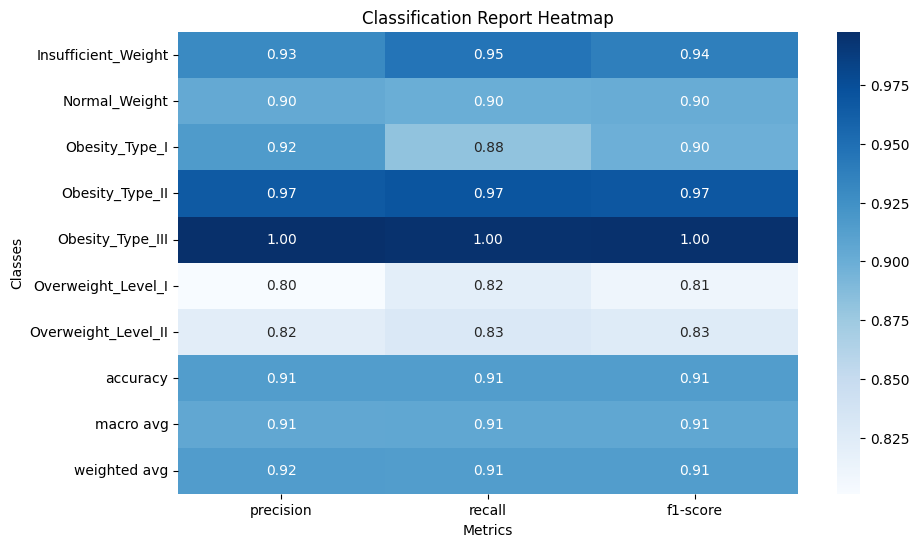

In [97]:
# Show classification report
clf_report = classification_report(y_test, y_pred, output_dict=True)
# Convert the dictionary to a DataFrame
clf_report_df = (
    pd.DataFrame(clf_report).iloc[:-1, :].T
)  # Exclude 'accuracy' row and transpose
# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))  # Explicitly create a figure
sns.heatmap(clf_report_df, annot=True, cmap="Blues", fmt=".2f", ax=ax)
ax.set_title("Classification Report Heatmap")
ax.set_xlabel("Metrics")
ax.set_ylabel("Classes")

In [98]:
# Assuming lgbm_classifier is your trained LightGBM model and X is your features dataset
feature_importance = lgbm_classifier.feature_importances_
feature_importance_df = pd.DataFrame(
    {"Feature": X.columns, "Importance": feature_importance}
)
feature_importance_df = feature_importance_df.sort_values(
    by="Importance", ascending=False
)
# Create and display the Seaborn barplot for feature importance

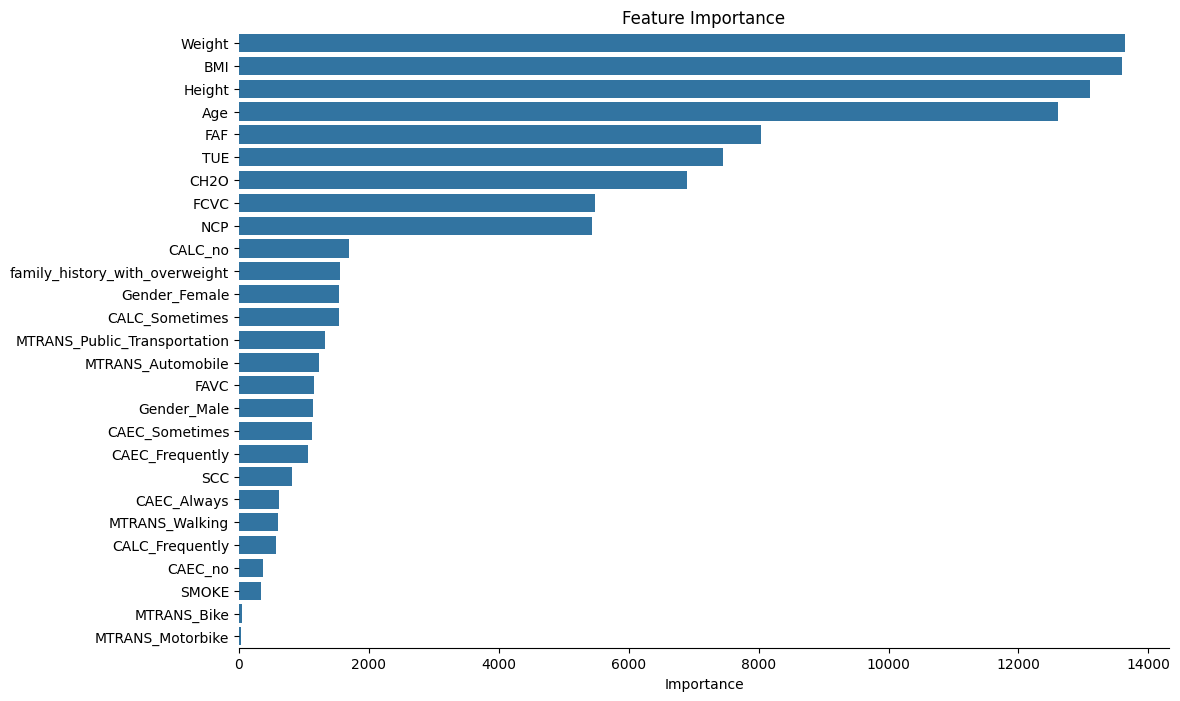

In [99]:
("Feature Importance Plot")
fig, ax = plt.subplots(figsize=(12, 8))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df, ax=ax)
ax.set_title("Feature Importance")
ax.set_xlabel("Importance")
ax.set_ylabel("")
sns.despine(left=True, bottom=False)

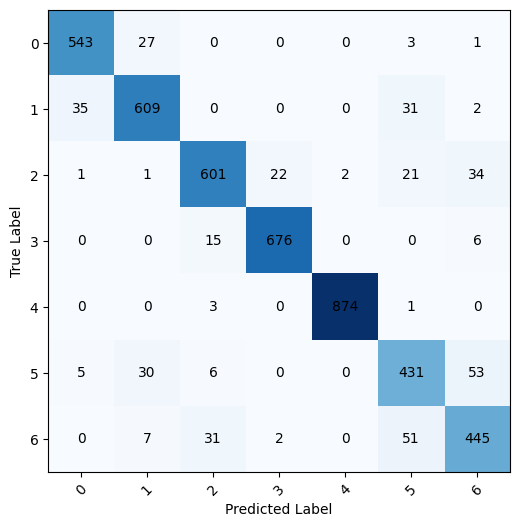

In [100]:
# Confusion matrix
plt.figure(figsize=(15, 6))
conf_matrix = confusion_matrix(y_test, y_pred)
conf_labels = [f"{i}" for i in range(conf_matrix.shape[0])]
conf_matrix_df = pd.DataFrame(conf_matrix, columns=conf_labels, index=conf_labels)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.xticks(np.arange(conf_matrix.shape[0]), conf_labels, rotation=45)
plt.yticks(np.arange(conf_matrix.shape[0]), conf_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), ha="center", va="center", color="black")
plt.grid(False)

## Model Insights

### Performance Overview


The classification model demonstrated excellent performance overall, as reflected in the heatmap. 
Most notably, the model excelled in identifying classes such as **Obesity_Type_III** and **Obesity_Type_II**, 
with near-perfect precision, recall, and F1-scores. This suggests that the features used to distinguish these classes are highly informative and separable.

Similarly, **Insufficient_Weight**, **Normal_Weight**, and **Obesity_Type_I** also exhibited strong performance, with scores ranging between 0.89 and 0.94 across all metrics, 
indicating that the model reliably differentiates these categories.

However, the model's performance on **Overweight_Level_I** and **Overweight_Level_II** was comparatively weaker, with precision, recall, and F1-scores hovering around 0.81 to 0.84. 
This could indicate some overlap in the feature space for these two classes or potentially a class imbalance in the training data. 
Such issues could lead the model to confuse these categories more frequently, thereby reducing its effectiveness.

The overall accuracy of **0.92** and a weighted average F1-score of **0.92** suggest that the model is robust and well-suited for the dataset. 
The macro average F1-score of **0.91** further indicates consistent performance across all classes, regardless of their size. 
However, addressing the discrepancies in **Overweight_Level_I** and **Overweight_Level_II** could enhance the model's overall performance.

This conclusion is also supported by the confusion matrix as it can be seen that the model correctly classified most of the datapoints.

Looking at the feature importance plot, we can see that the most relevant features were weight, height, age, physical activity, water consumption, vegetable consumption, the amount of time pend on electronics, and the number of meals they ate.

### Potential Improvements

If revisiting this project, some potential improvments or areas of further exploration are:

-exploring diffrent classification models and their relative performances

-exploring further means of pre-processing, such as normalizing data

-regressing over the BMI of an individual rather than their given weight classification.